# CS189 Final Project

Members:

Timothy Quang Nguyen, timotqn2@uci.edu

Aditya Pal Singh, adityapa@uci.edu

https://www.kaggle.com/datasets/yasserhessein/small-lung-nodule-lung-cancer-dataset/code

## Environment Setup

In [1]:
# # For package installations
# !pip install xgboost
# !pip install scikit-optimize
# !pip install pandas
# !pip install numpy
# !pip install seaborn
# !pip install matplotlib
# !pip install tensorflow
# !pip install shap

In [2]:
import numpy as np # for data organization
import pandas as pd # for data organization
import sklearn as sk # for machine learning

from sklearn.metrics import (confusion_matrix, accuracy_score, 
                            precision_score, recall_score, 
                            f1_score, roc_auc_score,
                            matthews_corrcoef, balanced_accuracy_score) # For Evaluation
from sklearn.preprocessing import MinMaxScaler # To Scale Features
from sklearn.preprocessing import OneHotEncoder, StandardScaler # To Encode Non-Numeric Columns
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score # For Hyper Parameter Tuning and Data Splitting
from skopt import BayesSearchCV # For Smart Hyper Parameter Tuning

from sklearn.linear_model import LogisticRegression # For Logistic Regression
from sklearn.ensemble import RandomForestClassifier # For Random Forest Classifier
from sklearn.svm import SVC # For Support Vector Classifier
from xgboost import XGBClassifier # For XGB Classifier
from sklearn.neural_network import MLPClassifier # For MLP Classifier

import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for plotting
import zipfile as zf # for unzipping data
import shap
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [3]:
# Code to extract dataset from zip (Don't need to run)

files = zf.ZipFile('archive.zip', 'r')
files.extractall('dataset')
files.close()

## Function Declarations

In [4]:
def evaluate_medical_model(y_true, y_pred, y_pred_proba=None, 
                          label_nums=[0,1], label_names=['Benign', 'Malignant']):
    """
    Comprehensive evaluation for medical binary classification.
    
    Parameters:
        y_true: True labels (array-like)
        y_pred: Predicted labels (array-like)
        y_pred_proba: Predicted probabilities (optional, for ROC-AUC)
        label_nums: Numeric labels [negative_class, positive_class]
        label_names: Descriptive label names
    """
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=label_nums)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=label_names, 
                yticklabels=label_names,
                annot_kws={"size": 14})
    plt.xlabel("Predicted", fontsize=12)
    plt.ylabel("True", fontsize=12)
    plt.title("Confusion Matrix", fontsize=14)
    plt.show()

    # Calculate metrics
    tn, fp, fn, tp = cm.ravel()
    
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Balanced Accuracy': balanced_accuracy_score(y_true, y_pred),
        'Precision (PPV)': precision_score(y_true, y_pred),
        'Recall (Sensitivity)': recall_score(y_true, y_pred),
        'Specificity': tn / (tn + fp),
        'F1 Score': f1_score(y_true, y_pred),
        'MCC': matthews_corrcoef(y_true, y_pred)
    }
    
    if y_pred_proba is not None:
        metrics['ROC-AUC'] = roc_auc_score(y_true, y_pred_proba)

    # Print formatted metrics
    print("\nMEDICAL DIAGNOSTICS METRICS")
    print("="*40)
    for name, value in metrics.items():
        if name in ['ROC-AUC', 'MCC']:  # Metrics that don't use percentage
            print(f"{name:<25}: {value:.4f}")
        else:
            print(f"{name:<25}: {value:.2%}")
    
    # Critical medical stats
    print("\nCRITICAL MEDICAL STATISTICS")
    print("="*40)
    print(f"False Negatives (Missed Cancer): {fn}")
    print(f"False Positives (Overdiagnosis): {fp}")
    print(f"Sensitivity (True Positive Rate): {metrics['Recall (Sensitivity)']:.2%}")
    print(f"Specificity (True Negative Rate): {metrics['Specificity']:.2%}")

In [5]:
# To showcase general data properties
def general_data_properties(data):
    rows, cols = data.shape

    print("Number of rows: ", rows)
    print("Number of columns: ", cols)
    print()
    print("All Columns:\n", data.columns)
    print()
    print("Column Types:\n", data.dtypes)

In [6]:
def non_matching_columns(dataset_one, dataset_two):
    non_matching = []
    dataset_one_cols = dataset_one.columns
    dataset_two_cols = dataset_two.columns
    
    for index in range(len(dataset_one_cols)):
        if dataset_one_cols[index] != dataset_two_cols[index]:
            non_matching.append((dataset_one_cols[index], dataset_two_cols[index]))

    return non_matching

In [7]:
def standardize_colnames(df):
    df.columns = df.columns.str.replace(r'(\.| )', '-', regex=True)  # Replace both dots and spaces with hyphens
    return df

## Loading Data

In [8]:
# Define paths (adjust as needed)
train_path = './dataset/Features_Train.csv'
test_path = './dataset/Lung Nodule/Lung Nodule/Features_Test.csv'

# Load data with error handling
try:
    train_data = pd.read_csv(train_path)
    print("Train data loaded successfully. Shape:", train_data.shape)
except FileNotFoundError:
    print(f"Error: {train_path} not found. Check the path or Kaggle dataset structure.")

try:
    test_data = pd.read_csv(test_path)
    print("Test data loaded successfully. Shape:", test_data.shape)
except FileNotFoundError:
    print(f"Error: {test_path} not found. Ensure the path matches the Kaggle folder.")

Train data loaded successfully. Shape: (609, 2000)
Test data loaded successfully. Shape: (127, 2000)


## Data Formatting

In [9]:
train_data = pd.read_csv(train_path) 
test_data = pd.read_csv(test_path)

In [10]:
# Check for column name inconsistency between the training and test data
non_matching = non_matching_columns(train_data, test_data)

print("Number of Non-Matching Columns: ", len(non_matching))
print("Non-Matching Columns:\n", non_matching)

Number of Non-Matching Columns:  30
Non-Matching Columns:
 [('Annulus_N.voxels', 'Annulus_N voxels'), ('Annulus_AUC.CSH', 'Annulus_AUC-CSH'), ('Annulus_AUC.CSH_LLL', 'Annulus_AUC-CSH_LLL'), ('Annulus_AUC.CSH_LLH', 'Annulus_AUC-CSH_LLH'), ('Annulus_AUC.CSH_LHL', 'Annulus_AUC-CSH_LHL'), ('Annulus_AUC.CSH_LHH', 'Annulus_AUC-CSH_LHH'), ('Annulus_AUC.CSH_HLL', 'Annulus_AUC-CSH_HLL'), ('Annulus_AUC.CSH_HLH', 'Annulus_AUC-CSH_HLH'), ('Annulus_AUC.CSH_HHL', 'Annulus_AUC-CSH_HHL'), ('Annulus_AUC.CSH_HHH', 'Annulus_AUC-CSH_HHH'), ('Background_N.voxels', 'Background_N voxels'), ('Background_AUC.CSH', 'Background_AUC-CSH'), ('Background_AUC.CSH_LLL', 'Background_AUC-CSH_LLL'), ('Background_AUC.CSH_LLH', 'Background_AUC-CSH_LLH'), ('Background_AUC.CSH_LHL', 'Background_AUC-CSH_LHL'), ('Background_AUC.CSH_LHH', 'Background_AUC-CSH_LHH'), ('Background_AUC.CSH_HLL', 'Background_AUC-CSH_HLL'), ('Background_AUC.CSH_HLH', 'Background_AUC-CSH_HLH'), ('Background_AUC.CSH_HHL', 'Background_AUC-CSH_HHL'), ('

In [11]:
# Standardize column names in both datasets
train_data = standardize_colnames(train_data)
test_data = standardize_colnames(test_data)

In [12]:
# After fixing, verify alignment
assert set(train_data.columns) == set(test_data.columns), "Columns still don't match!"
print("All columns now match!")

All columns now match!


In [13]:
# Combine "train" and "test" data for exploration
data = pd.concat([train_data, test_data], axis=0)

## Exploring Data

In [14]:
data

,ID,Annulus_N-voxels,Annulus_SNS_vol,Annulus_SNS_area,Annulus_SNS_s2v,Annulus_SNS_sph,Annulus_SNS_sph_dis,Annulus_SNS_com_1,Annulus_SNS_com_2,Annulus_SNS_max3d,...,Lesion_GLCM_sumEnt_HHH_25HUgl,Lesion_GLCM_difVar_HHH_25HUgl,Lesion_GLCM_difEnt_HHH_25HUgl,Lesion_GLCM_AutoCorrel_HHH_25HUgl,Lesion_GLCM_ClTend_HHH_25HUgl,Lesion_GLCM_Homoge1_HHH_25HUgl,Lesion_GLCM_IDMN_HHH_25HUgl,Lesion_GLCM_IDN_HHH_25HUgl,Lesion_GLCM_invVar_HHH_25HUgl,Outcome
0,0001_1,1504,1504,3364,2.236702,0.188709,5.299155,3.779511,0.006720,21,...,1.456343,0.516489,1.478822,12.359264,1.122325,0.672912,0.972564,0.898164,0.519051,0
1,0003_1,1007,1007,2224,2.208540,0.218459,4.577528,3.334505,0.010426,16,...,1.462379,0.535239,1.502895,12.134616,1.132018,0.675078,0.971933,0.898085,0.502191,0
2,0004_1,2160,2160,4322,2.000926,0.186969,5.348493,4.592921,0.006536,17,...,1.050196,0.245968,0.988000,2.261923,0.527141,0.763604,0.905442,0.842403,0.472791,1
3,0005_1,1568,1568,3276,2.089286,0.199237,5.019137,4.010592,0.007909,23,...,1.157852,0.299988,1.146312,6.241820,0.605958,0.733500,0.965438,0.891646,0.504706,1
4,0006_1,779,779,1702,2.184852,0.240556,4.157036,3.083113,0.013920,14,...,1.414994,0.484908,1.434273,6.282063,1.046868,0.692436,0.964913,0.889447,0.487179,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,0669_1,549,549,1200,2.185792,0.270199,3.700970,2.742900,0.019727,12,...,1.049768,0.243226,0.980279,2.258705,0.534523,0.767546,0.907018,0.845031,0.464908,0
123,0670_1,987,987,2126,2.154002,0.225493,4.434735,3.367958,0.011466,19,...,1.055271,0.246555,0.990005,2.280151,0.532569,0.766461,0.906585,0.844308,0.467077,0
124,0671_1,415,415,912,2.197590,0.295022,3.389576,2.489678,0.025678,11,...,1.009543,0.235130,0.956455,2.056056,0.507207,0.764303,0.905721,0.842868,0.471395,0
125,0671_2,665,665,1420,2.135338,0.259464,3.854101,2.969759,0.017467,14,...,1.061595,0.244005,0.982547,2.184166,0.550580,0.777429,0.910971,0.851619,0.445143,0


In [15]:
# Basic info
print("="*50)
general_data_properties(data)
print("="*50)

Number of rows:  736
Number of columns:  2000

All Columns:
 Index(['ID', 'Annulus_N-voxels', 'Annulus_SNS_vol', 'Annulus_SNS_area',
       'Annulus_SNS_s2v', 'Annulus_SNS_sph', 'Annulus_SNS_sph_dis',
       'Annulus_SNS_com_1', 'Annulus_SNS_com_2', 'Annulus_SNS_max3d',
       ...
       'Lesion_GLCM_sumEnt_HHH_25HUgl', 'Lesion_GLCM_difVar_HHH_25HUgl',
       'Lesion_GLCM_difEnt_HHH_25HUgl', 'Lesion_GLCM_AutoCorrel_HHH_25HUgl',
       'Lesion_GLCM_ClTend_HHH_25HUgl', 'Lesion_GLCM_Homoge1_HHH_25HUgl',
       'Lesion_GLCM_IDMN_HHH_25HUgl', 'Lesion_GLCM_IDN_HHH_25HUgl',
       'Lesion_GLCM_invVar_HHH_25HUgl', 'Outcome'],
      dtype='object', length=2000)

Column Types:
 ID                                 object
Annulus_N-voxels                    int64
Annulus_SNS_vol                     int64
Annulus_SNS_area                    int64
Annulus_SNS_s2v                   float64
                                   ...   
Lesion_GLCM_Homoge1_HHH_25HUgl    float64
Lesion_GLCM_IDMN_HHH_25HUgl  

In [16]:
# Show Basic Statistics
print("\nDescriptive Statistics:")
display(data.describe(include='all'))


Descriptive Statistics:


,ID,Annulus_N-voxels,Annulus_SNS_vol,Annulus_SNS_area,Annulus_SNS_s2v,Annulus_SNS_sph,Annulus_SNS_sph_dis,Annulus_SNS_com_1,Annulus_SNS_com_2,Annulus_SNS_max3d,...,Lesion_GLCM_sumEnt_HHH_25HUgl,Lesion_GLCM_difVar_HHH_25HUgl,Lesion_GLCM_difEnt_HHH_25HUgl,Lesion_GLCM_AutoCorrel_HHH_25HUgl,Lesion_GLCM_ClTend_HHH_25HUgl,Lesion_GLCM_Homoge1_HHH_25HUgl,Lesion_GLCM_IDMN_HHH_25HUgl,Lesion_GLCM_IDN_HHH_25HUgl,Lesion_GLCM_invVar_HHH_25HUgl,Outcome
count,736,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,...,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000
unique,736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,0658_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1267.789402,1267.789402,2688.967391,2.163961,0.222060,4.630233,3.537701,0.011900,18.148098,...,1.267868,0.575518,1.268956,9.961690,1.312101,0.706885,0.943140,0.871140,0.486404,0.512228
std,NaN,768.790967,768.790967,1542.952339,0.120870,0.037316,0.774405,0.785626,0.006223,5.122029,...,0.324784,1.437119,0.408007,23.260396,3.644784,0.081171,0.029496,0.026663,0.040155,0.500190
min,NaN,215.000000,215.000000,512.000000,1.831512,0.128838,2.950033,1.792757,0.002139,9.000000,...,0.918579,0.213436,0.888238,1.892398,0.444633,0.250460,0.885065,0.778880,0.173105,0.000000
25%,NaN,723.500000,723.500000,1576.000000,2.074736,0.194882,4.077933,2.984545,0.007401,14.000000,...,1.051109,0.247426,0.992535,2.291472,0.525994,0.679106,0.906709,0.843792,0.475426,0.000000
50%,NaN,1086.500000,1086.500000,2349.000000,2.154182,0.219097,4.564195,3.490809,0.010517,18.000000,...,1.120373,0.282039,1.100524,6.206917,0.586093,0.739958,0.954451,0.874570,0.492352,1.000000
75%,NaN,1641.500000,1641.500000,3466.500000,2.239256,0.245222,5.131319,4.066039,0.014746,21.000000,...,1.401194,0.483226,1.432721,11.770210,1.038824,0.759341,0.968895,0.895222,0.507041,1.000000


In [17]:
# Find Missing Values
print("Columns Missing Values:")
print(data.columns[data.isnull().any()].tolist())

Columns Missing Values:
[]


In [18]:
# Check for duplicates
print(f"Duplicate Rows: {data.duplicated().sum()}")

transposed_data = data.T
duplicate_columns = transposed_data.duplicated()

print(f"Duplicate Columns: {duplicate_columns.sum()}")

Duplicate Rows: 0
Duplicate Columns: 45


In [19]:
# Examine zero value distribution
numeric_cols = data.select_dtypes(include=np.number).columns.drop('Outcome')
print("Features with high number of zeros:")
print((data[numeric_cols] == 0).mean().sort_values(ascending=False).head(10))

Features with high number of zeros:
Lesion_FOS_Imode            0.010870
Annulus_FOS_Imode           0.006793
Annulus_FOS_Imax            0.002717
Lesion_FD_sd_HHH_25HUgl     0.002717
Lesion_FD_var_HHH_25HUgl    0.002717
Annulus_FOS_Imode_LLL       0.001359
Annulus_FOS_Imedian_HLH     0.001359
Annulus_FOS_Imedian_LHH     0.001359
Annulus_FOS_Imode_LHH       0.001359
Annulus_FOS_Imode_HLL       0.001359
dtype: float64


In [20]:
# Find all categorical columns
cat_cols = data.select_dtypes(include=['object', 'category']).columns
print("Categorical columns:", cat_cols.tolist())

Categorical columns: ['ID']


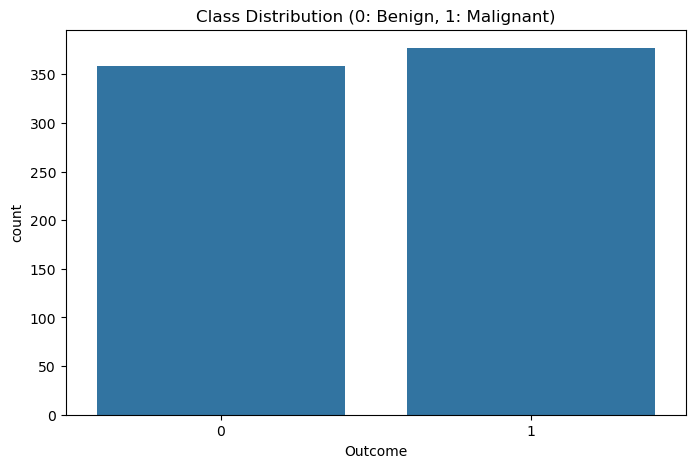

Class Distribution (%):
Outcome
1    51.222826
0    48.777174
Name: proportion, dtype: float64


In [21]:
# Class distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='Outcome')
plt.title('Class Distribution (0: Benign, 1: Malignant)')
plt.show()

# Percentage breakdown
class_dist = data['Outcome'].value_counts(normalize=True) * 100
print(f"Class Distribution (%):\n{class_dist}")

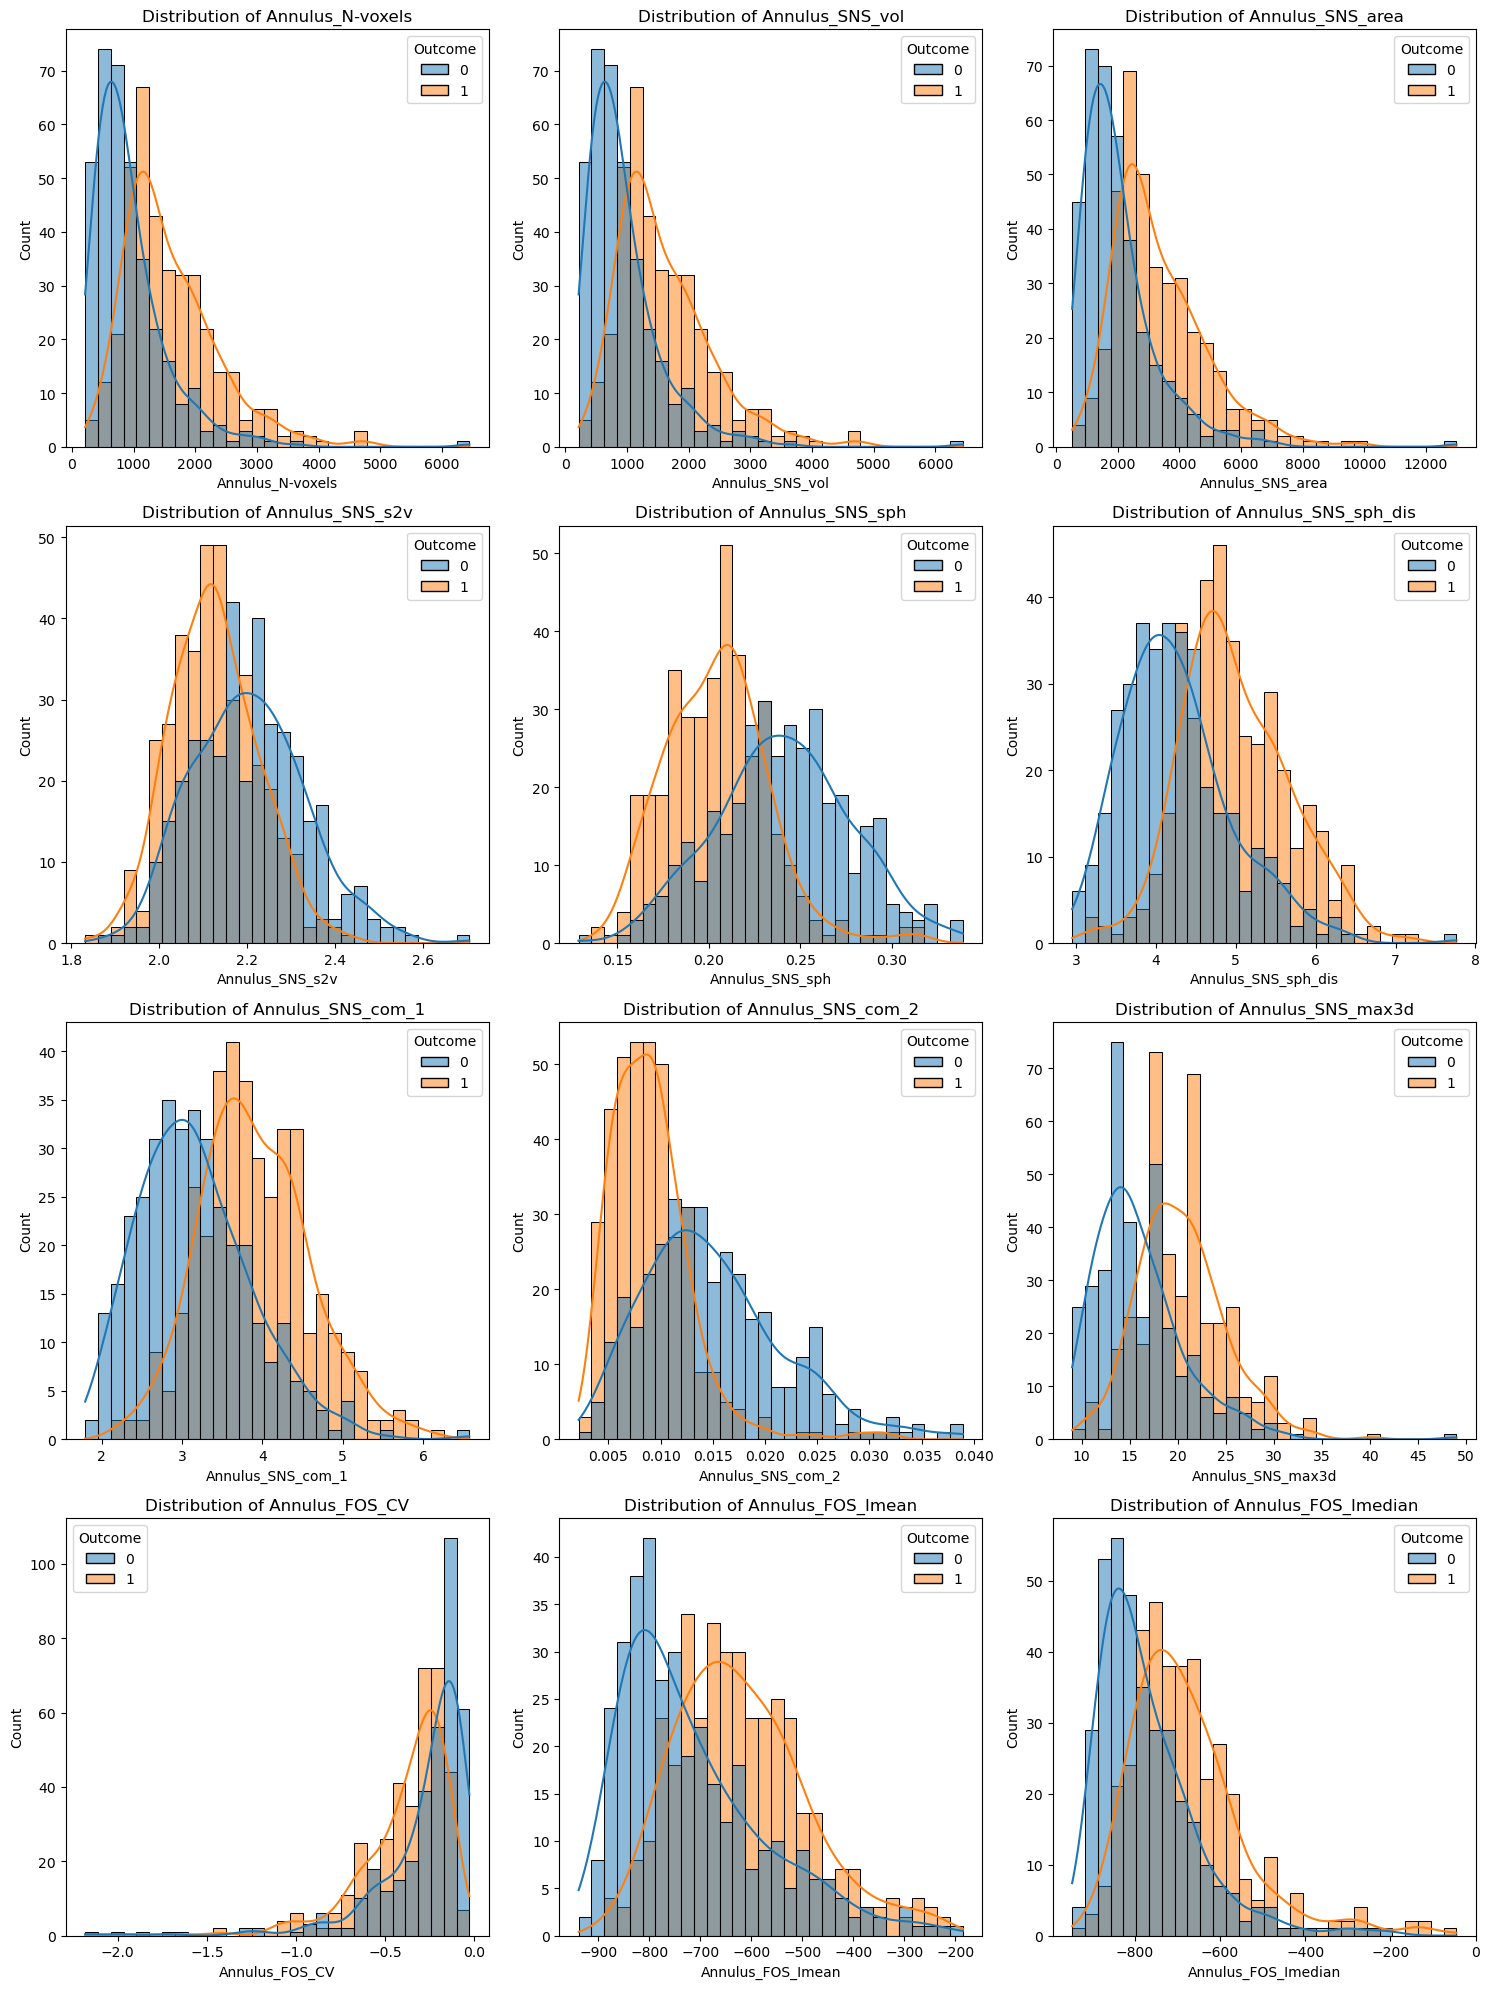

In [22]:
# Select numeric columns (excluding Outcome)
numeric_cols = data.select_dtypes(include=np.number).columns.drop('Outcome')

# Plot distributions
plt.figure(figsize=(15, 20))
for i, col in enumerate(numeric_cols[:12]):  # First 12 for brevity
    plt.subplot(4, 3, i+1)
    sns.histplot(data=data, x=col, kde=True, hue='Outcome', bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

Top 20 Features Correlated With Outcome:
Outcome                            1.000000
Lesion_GLCM_InfCo2_LHL_25HUgl      0.521858
Annulus_GLCM_Entrop_LLL_25HUgl     0.519752
Lesion_GLCM_IDMN_LLL_25HUgl        0.514141
Lesion_GLCM_IDMN_25HUgl            0.504609
Lesion_GLCM_InfCo2_HLL_25HUgl      0.503725
Lesion_GLCM_IDN_LLL_25HUgl         0.499335
Lesion_GLCM_InfCo1_LLL_25HUgl      0.492079
Lesion_GLCM_InfCo2_LLH_25HUgl      0.491890
Annulus_SNS_sph                    0.489287
Lesion_GLCM_Dissim_LLL_25HUgl      0.488402
Lesion_GLCM_InfCo2_LHH_25HUgl      0.484346
Lesion_GLCM_Contra_LLL_25HUgl      0.484162
Lesion_GLCM_InfCo1_HLL_25HUgl      0.479239
Lesion_GLCM_IDN_25HUgl             0.478385
Annulus_NGTDM_Coarse_HLH_25HUgl    0.477703
Annulus_SNS_com_1                  0.476046
Lesion_GLCM_InfCo1_LHL_25HUgl      0.475367
Annulus_SNS_com_2                  0.474960
Annulus_NGTDM_Coarse_HHL_25HUgl    0.474775
Name: Outcome, dtype: float64


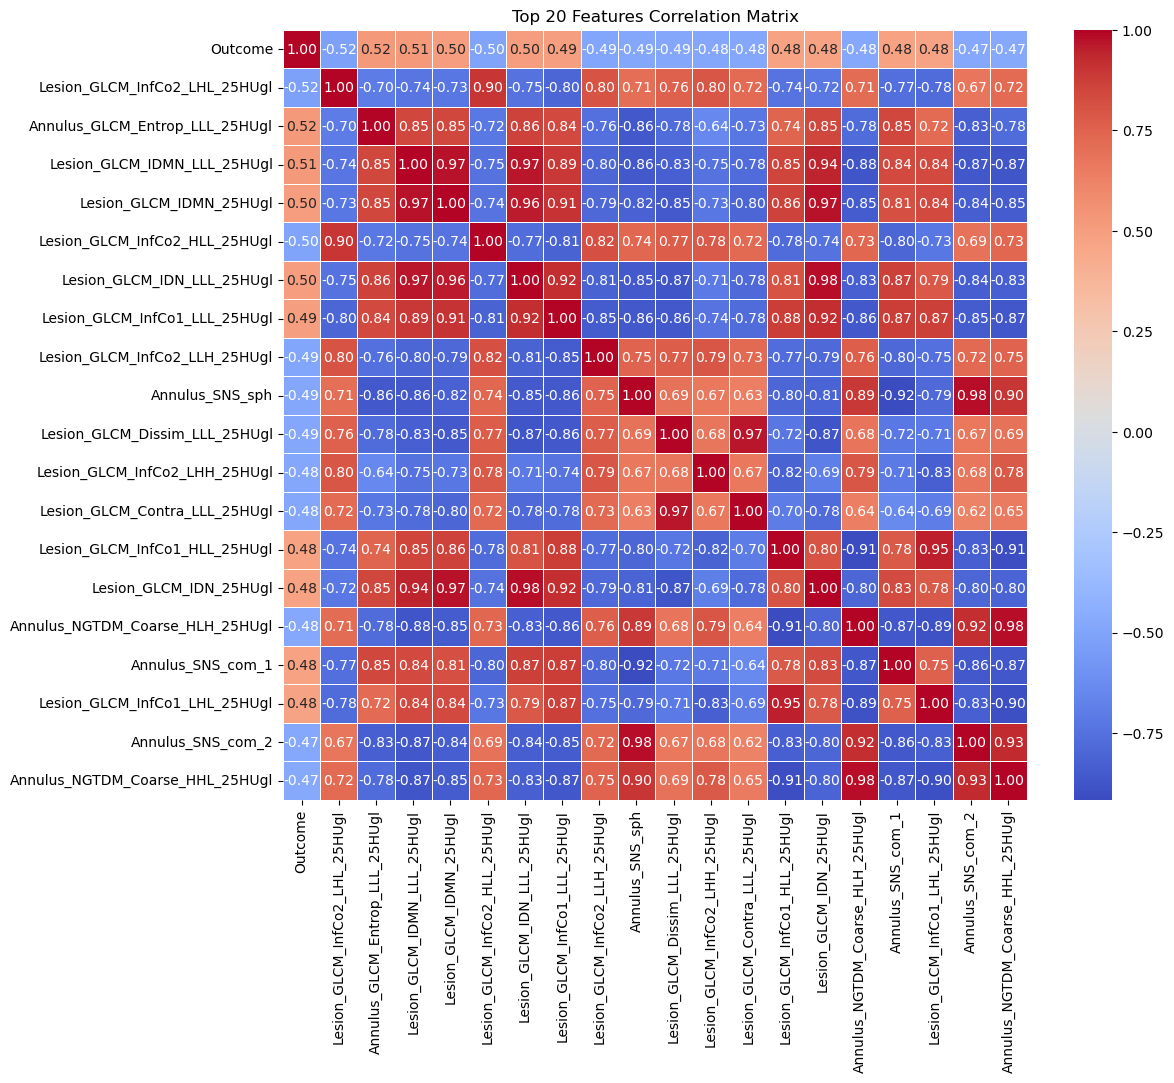

In [23]:
# Top correlations with Outcome
corr_matrix = data.corr()
outcome_corr = corr_matrix['Outcome'].abs().sort_values(ascending=False)
print("Top 20 Features Correlated With Outcome:")
print(outcome_corr.head(20))

# Correlation matrix
plt.figure(figsize=(12, 10))
top_corr_matrix = data[outcome_corr[:20].index.tolist()].corr()
sns.heatmap(top_corr_matrix, annot=True, cmap='coolwarm', fmt="0.2f", linewidth=0.5)
plt.title('Top 20 Features Correlation Matrix')
plt.show()

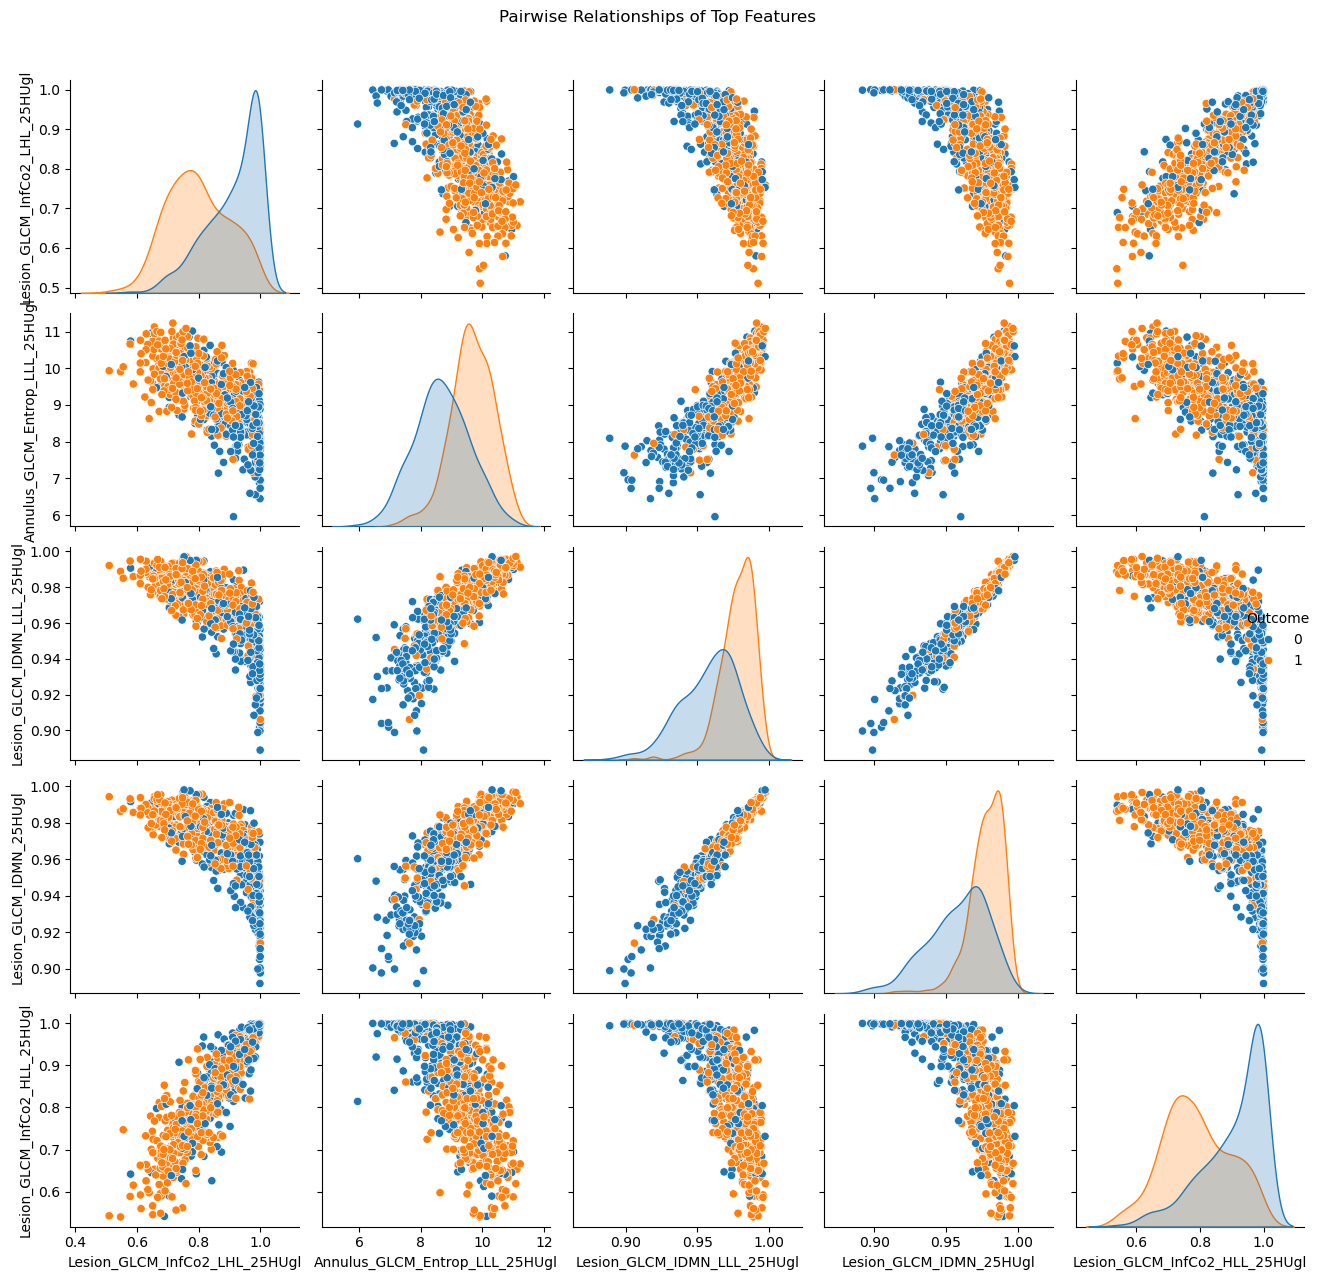

In [24]:
top_features = outcome_corr.index[1:6]  # Exclude Outcome itself
sns.pairplot(data=data[list(top_features) + ['Outcome']], hue='Outcome')
plt.suptitle('Pairwise Relationships of Top Features', y=1.02)
plt.tight_layout()
plt.show()

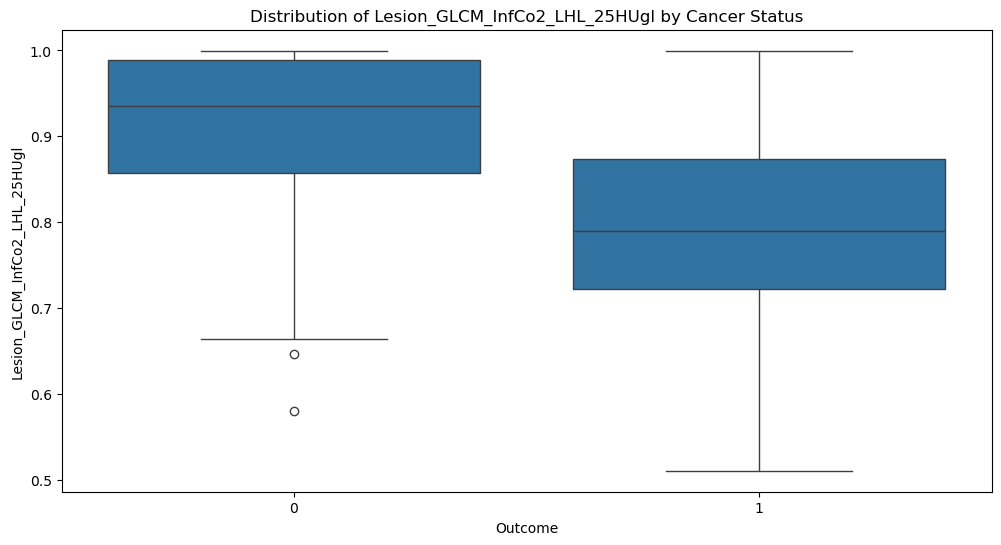

In [25]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='Outcome', y=top_features[0])  
plt.title(f'Distribution of {top_features[0]} by Cancer Status')
plt.show()

## Data Processing

### Drop ID and Duplicate Columns

In [26]:
data = data.drop('ID', axis=1)

duplicate_columns = pd.DataFrame(duplicate_columns[duplicate_columns == True]).index.tolist()
data = data.drop(duplicate_columns, axis=1)

print(data.shape)

(736, 1954)


### Use Top 1000 Correlated Features

In [27]:
# Find top correlated features without dropped columns
corr_matrix = data.corr()
outcome_corr = corr_matrix['Outcome'].abs().sort_values(ascending=False)

In [28]:
top_features = outcome_corr.index[:1001].tolist()
data_filtered = data[top_features]
print(data_filtered.columns)

Index(['Outcome', 'Lesion_GLCM_InfCo2_LHL_25HUgl',
       'Annulus_GLCM_Entrop_LLL_25HUgl', 'Lesion_GLCM_IDMN_LLL_25HUgl',
       'Lesion_GLCM_IDMN_25HUgl', 'Lesion_GLCM_InfCo2_HLL_25HUgl',
       'Lesion_GLCM_IDN_LLL_25HUgl', 'Lesion_GLCM_InfCo1_LLL_25HUgl',
       'Lesion_GLCM_InfCo2_LLH_25HUgl', 'Annulus_SNS_sph',
       ...
       'Background_GLRLM_LRLGLE_HHL_25HUgl', 'Annulus_GLCM_MxProb_HLL_25HUgl',
       'Lesion_GLCM_sumAvg_LHH_25HUgl', 'Annulus_GLCM_difVar_LHH_25HUgl',
       'Lesion_GLSZM_SzNonUnif_LHH_25HUgl', 'Lesion_FOS_Imax_HLH',
       'Background_FD_sd_LLH_25HUgl', 'Background_GLCM_Correl_LLL_25HUgl',
       'Lesion_GLSZM_SzNonUnif_HHL_25HUgl', 'Annulus_FD_min_LHH_25HUgl'],
      dtype='object', length=1001)


### Split X and Y Data

In [29]:
x_data = data_filtered.drop('Outcome', axis=1)
y_data = data_filtered['Outcome']

### Scale Data

In [30]:
scaler = StandardScaler()

x_data = pd.DataFrame(scaler.fit_transform(x_data), columns=x_data.columns)

x_data

,Lesion_GLCM_InfCo2_LHL_25HUgl,Annulus_GLCM_Entrop_LLL_25HUgl,Lesion_GLCM_IDMN_LLL_25HUgl,Lesion_GLCM_IDMN_25HUgl,Lesion_GLCM_InfCo2_HLL_25HUgl,Lesion_GLCM_IDN_LLL_25HUgl,Lesion_GLCM_InfCo1_LLL_25HUgl,Lesion_GLCM_InfCo2_LLH_25HUgl,Annulus_SNS_sph,Lesion_GLCM_Dissim_LLL_25HUgl,...,Background_GLRLM_LRLGLE_HHL_25HUgl,Annulus_GLCM_MxProb_HLL_25HUgl,Lesion_GLCM_sumAvg_LHH_25HUgl,Annulus_GLCM_difVar_LHH_25HUgl,Lesion_GLSZM_SzNonUnif_LHH_25HUgl,Lesion_FOS_Imax_HLH,Background_FD_sd_LLH_25HUgl,Background_GLCM_Correl_LLL_25HUgl,Lesion_GLSZM_SzNonUnif_HHL_25HUgl,Annulus_FD_min_LHH_25HUgl
0,0.376423,0.158471,-0.236491,-0.088551,0.867742,-0.399389,-0.130212,0.951116,-0.894353,0.593961,...,-0.767172,0.060780,0.693335,0.123567,0.900621,0.664492,0.567657,0.242266,0.365237,-1.183369
1,0.325323,-1.028108,0.244780,0.082029,0.114618,-0.085174,0.017493,-0.498588,-0.096583,0.150945,...,-0.899467,0.335537,0.302963,0.191639,0.113203,-0.061699,1.646066,0.045842,0.139556,-0.674763
2,-0.311436,0.150274,0.852703,0.763397,-0.520142,0.782050,0.596739,-0.449680,-0.941035,-0.683530,...,1.493374,0.748830,-0.574084,-0.563147,-0.319650,-0.985423,-1.806513,0.435386,-0.342398,1.418521
3,-1.654458,0.980710,0.504698,0.668978,-1.261707,0.481841,0.780941,-0.550020,-0.612026,-0.751780,...,-0.832749,-0.306335,-0.125557,-0.154555,-0.029919,-0.433859,1.387950,-0.481969,-0.161346,-0.674763
4,0.670342,-0.506451,-0.107896,-0.001291,0.789257,-0.215820,-0.638474,1.240380,0.495995,0.177326,...,-0.363373,-0.299973,-0.198074,-0.180461,-0.290293,0.406686,-1.090898,-1.071005,-0.240191,-0.674763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731,0.457073,-1.544310,-1.234890,-1.305674,0.835429,-1.320795,-1.136586,0.937807,1.290929,0.719213,...,1.683823,2.067598,-0.973656,-0.559587,-0.569687,-1.171728,0.066809,-0.259450,-0.472135,1.418521
732,-0.974534,-0.537975,-0.331339,-0.483033,-0.659826,-0.518726,0.169567,-0.812285,0.092047,0.189838,...,1.424322,1.041715,-0.574914,-0.510449,-0.400051,-1.015332,0.158710,0.242240,-0.455089,1.418521
733,1.100209,-1.642017,-1.909143,-2.143187,0.930963,-1.734081,-1.679165,1.487915,1.956590,1.719551,...,1.702953,2.752604,-0.742711,-0.533172,-0.528312,-0.797751,-1.394227,0.082624,-0.478953,1.418521
734,0.538958,-1.120529,-1.036937,-1.108446,0.440562,-1.109936,-0.852759,0.791182,1.003038,1.646423,...,1.520677,2.865877,-0.514225,-0.468126,-0.505815,-0.932695,-0.765103,0.279614,-0.467021,-0.310782


### Split Train and Test Data

In [31]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.15, random_state=142, stratify=y_data)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(625, 1000)
(111, 1000)
(625,)
(111,)


### Data Augmentation with Gaussian Noise

In [32]:
mean = 0
std_dev = 0.1
iteration = 3
rng = np.random.RandomState(142)

x_gaus = x_train.copy()
y_gaus = y_train.copy()

for i in range(iteration):
    noise = rng.normal(mean, std_dev, size=x_train.shape)
    x_copy = x_train + noise
    print("Noise Values:\n", noise)
    x_gaus = pd.concat([x_gaus, x_copy], axis=0)
    y_gaus = pd.concat([y_gaus, y_train], axis=0)

print()
print("New Training Data Shape:\n", x_gaus.shape, y_gaus.shape)

Noise Values:
 [[ 0.01297396  0.09023619  0.10058039 ...  0.04609184 -0.04615737
  -0.02787969]
 [ 0.02593821 -0.10713814  0.13637763 ... -0.15124123 -0.09914149
  -0.06189974]
 [ 0.01102679 -0.05235661  0.05533398 ...  0.02237019  0.0160023
  -0.13994665]
 ...
 [ 0.23004426  0.10796588 -0.03242979 ...  0.08921206 -0.06018207
  -0.11391117]
 [ 0.10180378  0.06633671  0.10909143 ... -0.06686846  0.11219693
  -0.01895625]
 [-0.08135543  0.03234256 -0.14678024 ... -0.09655358  0.08998112
   0.01779742]]
Noise Values:
 [[ 0.07988263 -0.11292155 -0.092891   ... -0.2242591   0.00598949
   0.05249546]
 [-0.13724468 -0.03316296  0.13580069 ... -0.01371729 -0.17017069
  -0.03875707]
 [-0.17450525 -0.17141162 -0.10293206 ... -0.17263036 -0.06648026
   0.17049192]
 ...
 [ 0.05094216  0.06878326 -0.18433477 ...  0.13920632 -0.02233803
  -0.19468229]
 [-0.05617113  0.13366692  0.04805271 ...  0.01860231  0.08045062
  -0.07802538]
 [-0.06947561 -0.00937702  0.18689771 ... -0.05507314 -0.08893114
  -

## Training Models

### Logistic Regression

In [33]:
# Linear Regression Model
lr_model = LogisticRegression(random_state=142, max_iter=500)
lr_model.fit(x_gaus, y_gaus)
lr_y_pred = lr_model.predict(x_test)

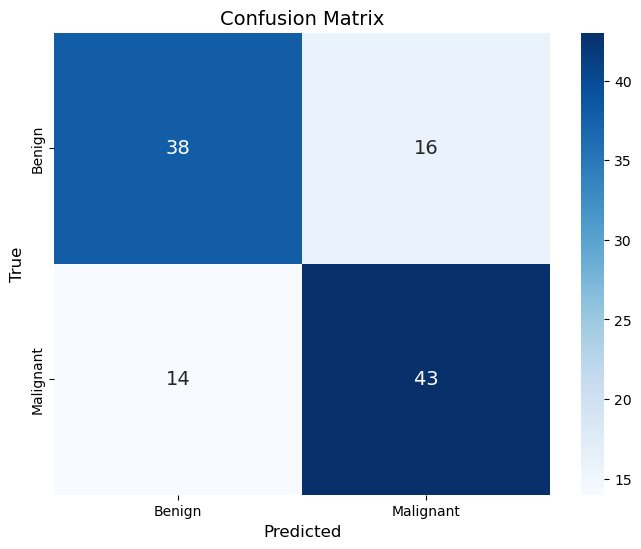


MEDICAL DIAGNOSTICS METRICS
Accuracy                 : 72.97%
Balanced Accuracy        : 72.90%
Precision (PPV)          : 72.88%
Recall (Sensitivity)     : 75.44%
Specificity              : 70.37%
F1 Score                 : 74.14%
MCC                      : 0.4588

CRITICAL MEDICAL STATISTICS
False Negatives (Missed Cancer): 14
False Positives (Overdiagnosis): 16
Sensitivity (True Positive Rate): 75.44%
Specificity (True Negative Rate): 70.37%


In [34]:
# Logistic Regression Evaluation
evaluate_medical_model(y_test, lr_y_pred)

### Random Forest

In [35]:
# Random Forest Classifier Model
rf_model = RandomForestClassifier(random_state=142)
rf_model.fit(x_gaus, y_gaus)
rf_y_pred = rf_model.predict(x_test)

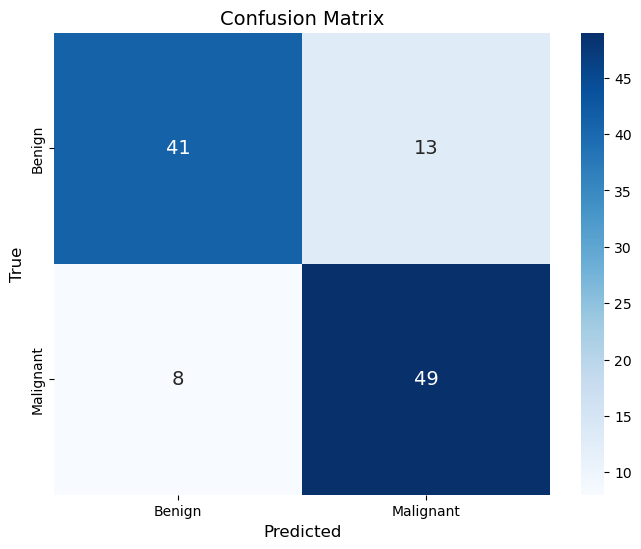


MEDICAL DIAGNOSTICS METRICS
Accuracy                 : 81.08%
Balanced Accuracy        : 80.95%
Precision (PPV)          : 79.03%
Recall (Sensitivity)     : 85.96%
Specificity              : 75.93%
F1 Score                 : 82.35%
MCC                      : 0.6230

CRITICAL MEDICAL STATISTICS
False Negatives (Missed Cancer): 8
False Positives (Overdiagnosis): 13
Sensitivity (True Positive Rate): 85.96%
Specificity (True Negative Rate): 75.93%


In [36]:
# Random Forest Evaluation
evaluate_medical_model(y_test, rf_y_pred)

### Random Forest Tuned

In [757]:
# Use Bayesian Optimization to find the best set of hyperparameters
rf_params = {"n_estimators": (10, 500), 
              "max_features": ["sqrt", "log2", 0.2, 0.5, 0.7, 1],
              "max_depth": [3, 5, 10, 15, 20, None], 
              "min_samples_leaf": (1, 15)}

rf_opt = BayesSearchCV(RandomForestClassifier(random_state=142), rf_params, verbose=3, n_iter=50)
rf_opt.fit(x_gaus, y_gaus)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=None, max_features=1, min_samples_leaf=15, n_estimators=76;, score=0.824 total time=   0.2s
[CV 2/5] END max_depth=None, max_features=1, min_samples_leaf=15, n_estimators=76;, score=0.812 total time=   0.2s
[CV 3/5] END max_depth=None, max_features=1, min_samples_leaf=15, n_estimators=76;, score=0.792 total time=   0.2s
[CV 4/5] END max_depth=None, max_features=1, min_samples_leaf=15, n_estimators=76;, score=0.828 total time=   0.2s
[CV 5/5] END max_depth=None, max_features=1, min_samples_leaf=15, n_estimators=76;, score=0.826 total time=   0.2s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=15, max_features=0.7, min_samples_leaf=1, n_estimators=112;, score=0.970 total time= 2.9min
[CV 2/5] END max_depth=15, max_features=0.7, min_samples_leaf=1, n_estimators=112;, score=0.984 total time= 2.9min
[CV 3/5] END max_depth=15, max_features=0.7, min_samples_leaf=1, n_estimators

C:\Users\HP\miniconda3\envs\cs189\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [None, np.str_('sqrt'), np.int64(1), np.int64(500)] before, using random point [5, 1, np.int64(4), np.int64(424)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=5, max_features=1, min_samples_leaf=4, n_estimators=424;, score=0.786 total time=   1.1s
[CV 2/5] END max_depth=5, max_features=1, min_samples_leaf=4, n_estimators=424;, score=0.796 total time=   1.0s
[CV 3/5] END max_depth=5, max_features=1, min_samples_leaf=4, n_estimators=424;, score=0.790 total time=   1.0s
[CV 4/5] END max_depth=5, max_features=1, min_samples_leaf=4, n_estimators=424;, score=0.804 total time=   1.0s
[CV 5/5] END max_depth=5, max_features=1, min_samples_leaf=4, n_estimators=424;, score=0.806 total time=   1.0s


C:\Users\HP\miniconda3\envs\cs189\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20), np.str_('sqrt'), np.int64(1), np.int64(500)] before, using random point [20, 0.2, np.int64(6), np.int64(473)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=20, max_features=0.2, min_samples_leaf=6, n_estimators=473;, score=0.972 total time= 2.8min
[CV 2/5] END max_depth=20, max_features=0.2, min_samples_leaf=6, n_estimators=473;, score=0.972 total time= 2.9min
[CV 3/5] END max_depth=20, max_features=0.2, min_samples_leaf=6, n_estimators=473;, score=0.974 total time= 2.8min
[CV 4/5] END max_depth=20, max_features=0.2, min_samples_leaf=6, n_estimators=473;, score=0.980 total time= 2.7min
[CV 5/5] END max_depth=20, max_features=0.2, min_samples_leaf=6, n_estimators=473;, score=0.974 total time= 2.8min
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=20, max_features=0.2, min_samples_leaf=1, n_estimators=500;, score=0.990 total time= 3.9min
[CV 2/5] END max_depth=20, max_features=0.2, min_samples_leaf=1, n_estimators=500;, score=0.992 total time= 3.9min
[CV 3/5] END max_depth=20, max_features=0.2, min_samples_leaf=1, n_estimators

C:\Users\HP\miniconda3\envs\cs189\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(15), np.str_('sqrt'), np.int64(1), np.int64(500)] before, using random point [5, 0.7, np.int64(5), np.int64(433)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=5, max_features=0.7, min_samples_leaf=5, n_estimators=433;, score=0.864 total time= 5.1min
[CV 2/5] END max_depth=5, max_features=0.7, min_samples_leaf=5, n_estimators=433;, score=0.868 total time= 4.9min
[CV 3/5] END max_depth=5, max_features=0.7, min_samples_leaf=5, n_estimators=433;, score=0.866 total time= 4.7min
[CV 4/5] END max_depth=5, max_features=0.7, min_samples_leaf=5, n_estimators=433;, score=0.884 total time= 4.7min
[CV 5/5] END max_depth=5, max_features=0.7, min_samples_leaf=5, n_estimators=433;, score=0.872 total time= 4.7min


C:\Users\HP\miniconda3\envs\cs189\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(15), np.str_('sqrt'), np.int64(1), np.int64(500)] before, using random point [15, 0.7, np.int64(14), np.int64(327)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=15, max_features=0.7, min_samples_leaf=14, n_estimators=327;, score=0.930 total time= 5.4min
[CV 2/5] END max_depth=15, max_features=0.7, min_samples_leaf=14, n_estimators=327;, score=0.918 total time= 5.5min
[CV 3/5] END max_depth=15, max_features=0.7, min_samples_leaf=14, n_estimators=327;, score=0.922 total time= 5.3min
[CV 4/5] END max_depth=15, max_features=0.7, min_samples_leaf=14, n_estimators=327;, score=0.936 total time= 5.4min
[CV 5/5] END max_depth=15, max_features=0.7, min_samples_leaf=14, n_estimators=327;, score=0.932 total time= 5.5min


C:\Users\HP\miniconda3\envs\cs189\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(15), np.str_('sqrt'), np.int64(1), np.int64(500)] before, using random point [20, 0.5, np.int64(11), np.int64(341)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=20, max_features=0.5, min_samples_leaf=11, n_estimators=341;, score=0.948 total time= 4.3min
[CV 2/5] END max_depth=20, max_features=0.5, min_samples_leaf=11, n_estimators=341;, score=0.952 total time= 4.3min
[CV 3/5] END max_depth=20, max_features=0.5, min_samples_leaf=11, n_estimators=341;, score=0.948 total time= 4.2min
[CV 4/5] END max_depth=20, max_features=0.5, min_samples_leaf=11, n_estimators=341;, score=0.964 total time= 4.2min
[CV 5/5] END max_depth=20, max_features=0.5, min_samples_leaf=11, n_estimators=341;, score=0.946 total time= 4.4min
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=20, max_features=0.7, min_samples_leaf=1, n_estimators=10;, score=0.976 total time=  16.4s
[CV 2/5] END max_depth=20, max_features=0.7, min_samples_leaf=1, n_estimators=10;, score=0.966 total time=  16.1s
[CV 3/5] END max_depth=20, max_features=0.7, min_samples_leaf=1, n_estimat

BayesSearchCV(estimator=RandomForestClassifier(random_state=142),
              search_spaces={'max_depth': [3, 5, 10, 15, 20, None],
                             'max_features': ['sqrt', 'log2', 0.2, 0.5, 0.7, 1],
                             'min_samples_leaf': (1, 15),
                             'n_estimators': (10, 500)},
              verbose=3)

In [37]:
# Random Forest Classifier Model
#print(rf_opt.best_estimator_)
#rf_model_tuned = rf_opt.best_estimator_
rf_model_tuned = RandomForestClassifier(max_depth=None, max_features=0.2, min_samples_leaf=8, n_estimators=44, random_state=142)
rf_model_tuned.fit(x_gaus, y_gaus)
rf_tuned_y_pred = rf_model_tuned.predict(x_test)

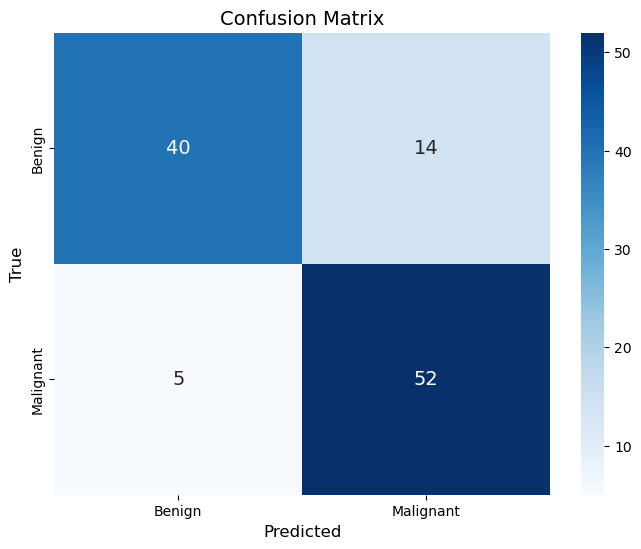


MEDICAL DIAGNOSTICS METRICS
Accuracy                 : 82.88%
Balanced Accuracy        : 82.65%
Precision (PPV)          : 78.79%
Recall (Sensitivity)     : 91.23%
Specificity              : 74.07%
F1 Score                 : 84.55%
MCC                      : 0.6648

CRITICAL MEDICAL STATISTICS
False Negatives (Missed Cancer): 5
False Positives (Overdiagnosis): 14
Sensitivity (True Positive Rate): 91.23%
Specificity (True Negative Rate): 74.07%


In [38]:
# Random Forest Evaluation
evaluate_medical_model(y_test, rf_tuned_y_pred)

### SVC

In [39]:
# SVC Model
svc_model = SVC(random_state=142)
svc_model.fit(x_gaus, y_gaus)
svc_y_pred = rf_model.predict(x_test)

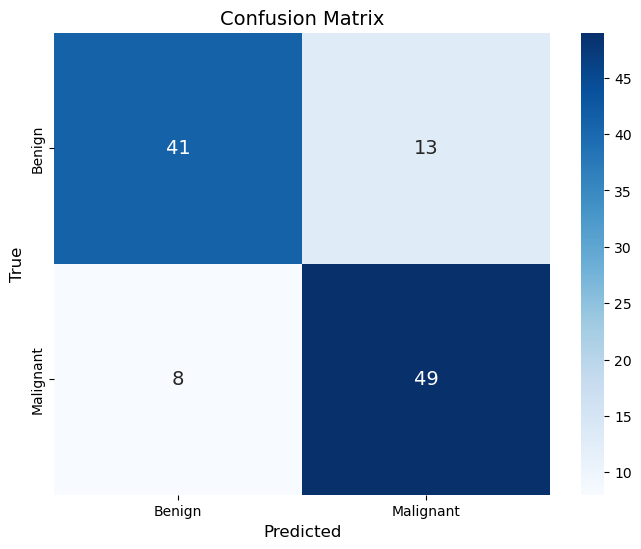


MEDICAL DIAGNOSTICS METRICS
Accuracy                 : 81.08%
Balanced Accuracy        : 80.95%
Precision (PPV)          : 79.03%
Recall (Sensitivity)     : 85.96%
Specificity              : 75.93%
F1 Score                 : 82.35%
MCC                      : 0.6230

CRITICAL MEDICAL STATISTICS
False Negatives (Missed Cancer): 8
False Positives (Overdiagnosis): 13
Sensitivity (True Positive Rate): 85.96%
Specificity (True Negative Rate): 75.93%


In [40]:
# SVC Evaluation
evaluate_medical_model(y_test, svc_y_pred)

### SVC Tuned

In [760]:
# Use Bayesian Optimization to find the best set of hyperparameters
svc_params = {"kernel": ["poly", "rbf", "sigmoid"], 
            "degree": (0, 10), 
            "gamma": ["scale", "auto", 1, 0.1, 0.001, 0.0001], 
            "C": (0.001, 1000)}

svc_opt = BayesSearchCV(SVC(random_state=142), svc_params, verbose=3, n_iter=50)
svc_opt.fit(x_gaus, y_gaus)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END C=85.60911931314811, degree=3, gamma=0.001, kernel=poly;, score=1.000 total time=   0.9s
[CV 2/5] END C=85.60911931314811, degree=3, gamma=0.001, kernel=poly;, score=1.000 total time=   1.0s
[CV 3/5] END C=85.60911931314811, degree=3, gamma=0.001, kernel=poly;, score=1.000 total time=   0.8s
[CV 4/5] END C=85.60911931314811, degree=3, gamma=0.001, kernel=poly;, score=1.000 total time=   0.7s
[CV 5/5] END C=85.60911931314811, degree=3, gamma=0.001, kernel=poly;, score=1.000 total time=   0.8s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END C=722.5185618767757, degree=9, gamma=auto, kernel=sigmoid;, score=0.648 total time=   0.7s
[CV 2/5] END C=722.5185618767757, degree=9, gamma=auto, kernel=sigmoid;, score=0.672 total time=   0.6s
[CV 3/5] END C=722.5185618767757, degree=9, gamma=auto, kernel=sigmoid;, score=0.666 total time=   0.6s
[CV 4/5] END C=722.5185618767757, degree=9, gamma=auto, kern

BayesSearchCV(estimator=SVC(random_state=142),
              search_spaces={'C': (0.001, 1000), 'degree': (0, 10),
                             'gamma': ['scale', 'auto', 1, 0.1, 0.001, 0.0001],
                             'kernel': ['poly', 'rbf', 'sigmoid']},
              verbose=3)

In [148]:
# SVC Model
#print(svc_opt.best_estimator_)
#svc_model_tuned = svc_opt.best_estimator_
svc_model_tuned = SVC(C=100, gamma="auto", kernel="rbf", random_state=142)
svc_model_tuned.fit(x_gaus, y_gaus)
svc_tuned_y_pred = svc_model_tuned.predict(x_test)

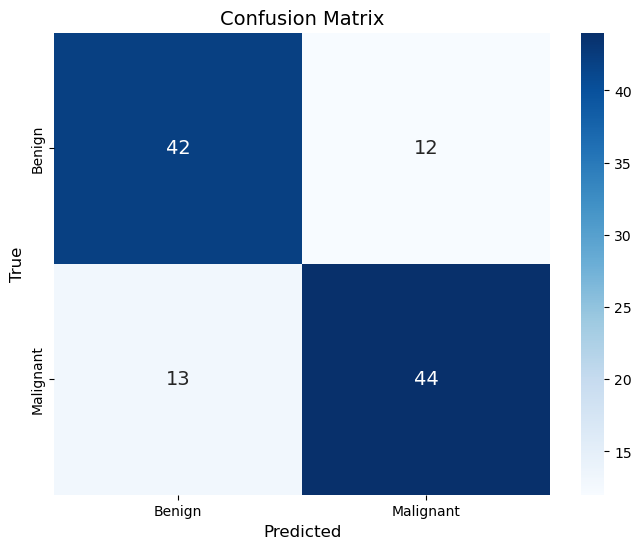


MEDICAL DIAGNOSTICS METRICS
Accuracy                 : 77.48%
Balanced Accuracy        : 77.49%
Precision (PPV)          : 78.57%
Recall (Sensitivity)     : 77.19%
Specificity              : 77.78%
F1 Score                 : 77.88%
MCC                      : 0.5495

CRITICAL MEDICAL STATISTICS
False Negatives (Missed Cancer): 13
False Positives (Overdiagnosis): 12
Sensitivity (True Positive Rate): 77.19%
Specificity (True Negative Rate): 77.78%


In [149]:
# SVC Evaluation
evaluate_medical_model(y_test, svc_tuned_y_pred)

### XGB

In [204]:
# XGB Model
xgb_model = XGBClassifier(random_state=142)
xgb_model.fit(x_gaus, y_gaus)
xgb_y_pred = xgb_model.predict(x_test)

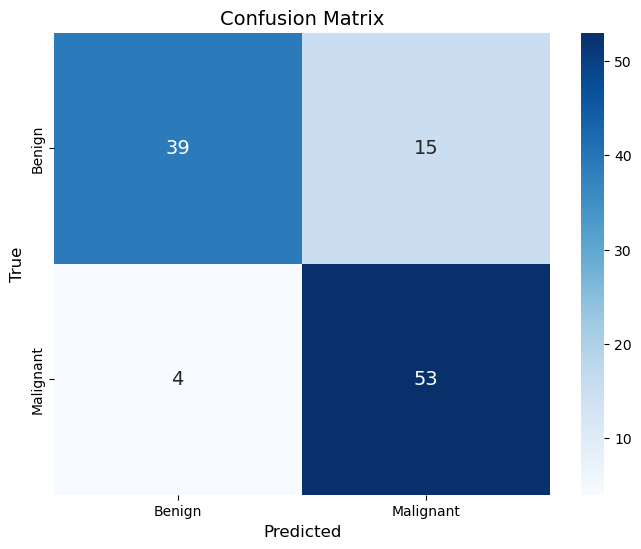


MEDICAL DIAGNOSTICS METRICS
Accuracy                 : 82.88%
Balanced Accuracy        : 82.60%
Precision (PPV)          : 77.94%
Recall (Sensitivity)     : 92.98%
Specificity              : 72.22%
F1 Score                 : 84.80%
MCC                      : 0.6690

CRITICAL MEDICAL STATISTICS
False Negatives (Missed Cancer): 4
False Positives (Overdiagnosis): 15
Sensitivity (True Positive Rate): 92.98%
Specificity (True Negative Rate): 72.22%


In [205]:
# XGB Evaluation
evaluate_medical_model(y_test, xgb_y_pred)

### XGB Tuned

In [763]:
# Use Bayesian Optimization to find the best set of hyperparameters
xgb_params = {"n_estimators": (10, 500), 
              "eta": (0.0001, 1),
              "max_depth": (1, 9), 
              "subsample": (0.1, 1), 
              "colsample_bytree": (0.1, 1)}

xgb_opt = BayesSearchCV(XGBClassifier(random_state=142), xgb_params, verbose=3, n_iter=50)
xgb_opt.fit(x_gaus, y_gaus)
xgb_opt.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END colsample_bytree=0.5082438772464307, eta=0.13241081027287313, max_depth=5, n_estimators=408, subsample=0.5392796636114684;, score=1.000 total time=   7.0s
[CV 2/5] END colsample_bytree=0.5082438772464307, eta=0.13241081027287313, max_depth=5, n_estimators=408, subsample=0.5392796636114684;, score=1.000 total time=   6.9s
[CV 3/5] END colsample_bytree=0.5082438772464307, eta=0.13241081027287313, max_depth=5, n_estimators=408, subsample=0.5392796636114684;, score=0.998 total time=   6.9s
[CV 4/5] END colsample_bytree=0.5082438772464307, eta=0.13241081027287313, max_depth=5, n_estimators=408, subsample=0.5392796636114684;, score=0.998 total time=   6.8s
[CV 5/5] END colsample_bytree=0.5082438772464307, eta=0.13241081027287313, max_depth=5, n_estimators=408, subsample=0.5392796636114684;, score=1.000 total time=   7.0s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END colsample_bytree=0.2801090812

OrderedDict([('colsample_bytree', 0.7857442773987161),
             ('eta', 0.18146671974238948),
             ('max_depth', 3),
             ('n_estimators', 500),
             ('subsample', 0.9457105372921774)])

In [201]:
# XGB Model
#print(xgb_opt.best_estimator_)
#xgb_model_tuned = xgb_opt.best_estimator_
xgb_model_tuned = XGBClassifier(colsample_bytree=1.0, eta=0.4296003892608431, max_depth=1, n_estimators=286, subsample=0.866261190791479, random_state=142)
xgb_model_tuned.fit(x_gaus, y_gaus)
xgb_tuned_y_pred = xgb_model_tuned.predict(x_test)

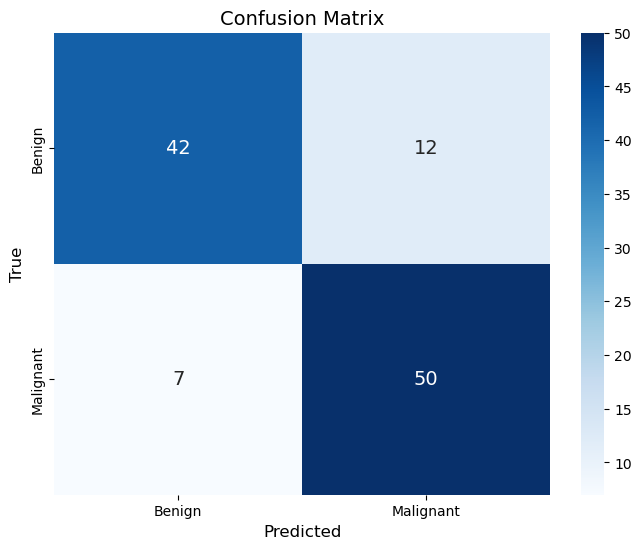


MEDICAL DIAGNOSTICS METRICS
Accuracy                 : 82.88%
Balanced Accuracy        : 82.75%
Precision (PPV)          : 80.65%
Recall (Sensitivity)     : 87.72%
Specificity              : 77.78%
F1 Score                 : 84.03%
MCC                      : 0.6593

CRITICAL MEDICAL STATISTICS
False Negatives (Missed Cancer): 7
False Positives (Overdiagnosis): 12
Sensitivity (True Positive Rate): 87.72%
Specificity (True Negative Rate): 77.78%


In [202]:
# Random Forest Evaluation
evaluate_medical_model(y_test, xgb_tuned_y_pred)

## Model Comparison

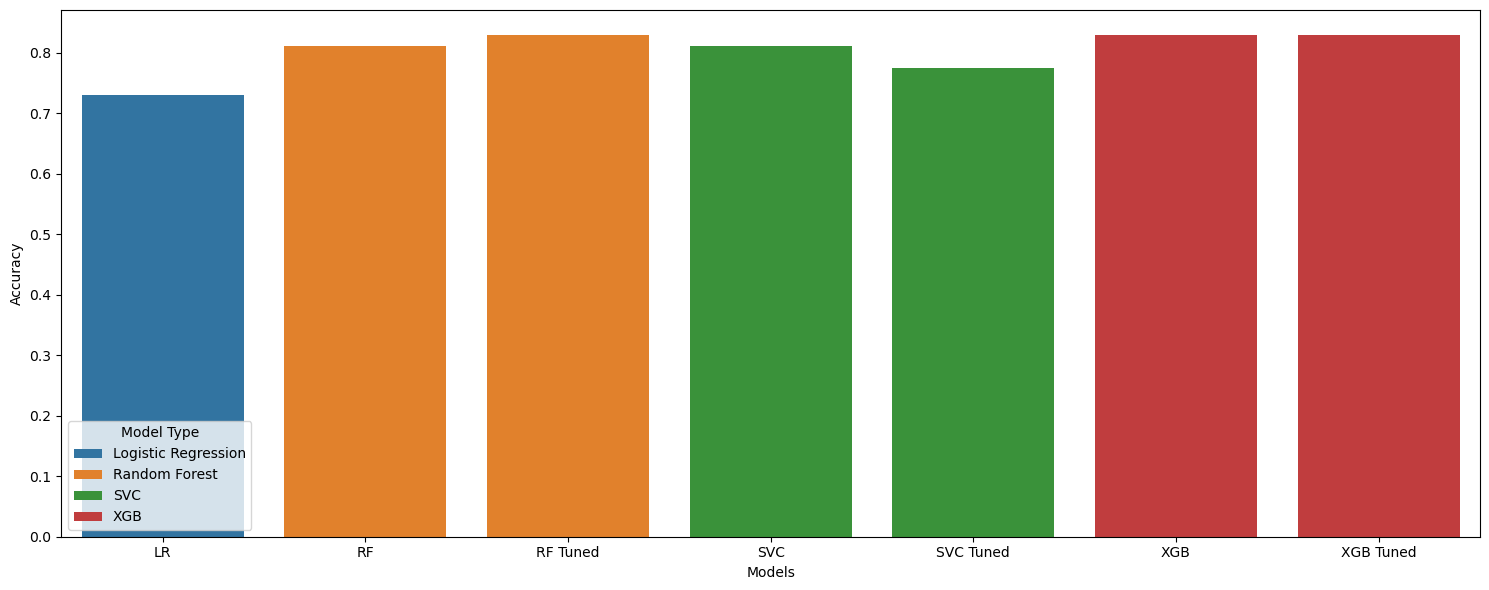

In [206]:
models = ["LR",  
          "RF", 
          "RF Tuned", 
          "SVC", 
          "SVC Tuned", 
          "XGB", 
          "XGB Tuned"]

accuracies = [accuracy_score(y_test, lr_y_pred), 
              accuracy_score(y_test, rf_y_pred), 
              accuracy_score(y_test, rf_tuned_y_pred), 
              accuracy_score(y_test, svc_y_pred), 
              accuracy_score(y_test, svc_tuned_y_pred), 
              accuracy_score(y_test, xgb_y_pred), 
              accuracy_score(y_test, xgb_tuned_y_pred)]

model_type = ["Logistic Regression", 
              "Random Forest", "Random Forest", 
              "SVC", "SVC", 
              "XGB", "XGB"]

comparison_data = pd.DataFrame({"Model Type": model_type, "Accuracy": accuracies, "Models": models})

fig, ax = plt.subplots(figsize=(15, 6))

sns.barplot(x="Models", y="Accuracy", data=comparison_data, hue="Model Type", ax=ax)
sns.move_legend(ax, "lower left")
plt.tight_layout()
plt.show()

## References

1. Gaussian Noise: https://medium.com/@ms_somanna/guide-to-adding-noise-to-your-data-using-python-and-numpy-c8be815df524
2. Data Augmentation: https://medium.com/@yusufrufaiabdullahi/a-comprehensive-guide-to-numerical-data-augmentation-4563b322b6b7
3. Duplicate Rows/Columns: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.duplicated.html